# Desafío - Mecanismos de Votación

Nombre: **Verónica Martínez**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Generación **G4**

Profesor: Josué Fredes

## Descripción
Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o inpopularidad de contenido en línea de un sitio web. El archivo `csv` tiene un total de 39797 registros, donde cada uno representa características del artículo publicado en el sitio web. Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.. Los artículos registrados son de la página web www.mashable.com.

Más información sobre los atributos se puede encontrar en el archivo `OnlineNewsPopularity.names`.

## Ejercicio 1 - Preparación del Ambiente de Trabajo
A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función `grid_plot_batch` que se encuentra en el archivo `helpers.py`.

```python
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]

# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']

# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)
```

- Describa el comportamiento de las variables.
- Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función `identify_high_correlations` que se encuentra en el archivo `helpers.py`. Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.
- Antes de generar los conjuntos de entrenamiento y validación, preprocese los datos con los siguientes pasos:
  - Recodifique la variable `shares` en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable `shares` posteriormente.
  - Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
  - Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hlp
import re
from time import time

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
#Importar datos
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')
df.sample(3).T

35770  \
url                             http://mashable.com/2014/10/29/facebook-stock-...   
 timedelta                                                                     70   
 n_tokens_title                                                                 9   
 n_tokens_content                                                             223   
 n_unique_tokens                                                         0.515695   
 n_non_stop_words                                                               1   
 n_non_stop_unique_tokens                                                0.535032   
 num_hrefs                                                                     21   
 num_self_hrefs                                                                 3   
 num_imgs                                                                      16   
 num_videos                                                                     1   
 average_token_length                                                     4.67265   
 num_keywords                                                                   9   
 data_channel_is_lifestyle                                                      0   
 data_channel_is_entertainment                                                  0   
 data_channel_is_bus                                                            0   
 data_channel_is_socmed                                                         0   
 data_channel_is_tech                                                           0   
 data_channel_is_world                                                          0   
 kw_min_min                                                                    -1   
 kw_max_min                                                                  1600   
 kw_avg_min                                                               296.778   
 kw_min_max                                                                 11900   
 kw_max_max                                                                843300   
 kw_avg_max                                                                264267   
 kw_min_avg                                                               3443.26   
 kw_max_avg                                                               8224.36   
 kw_avg_avg                                                               5974.32   
 self_reference_min_shares                                                   1100   
 self_reference_max_shares                                                  12300   
...                                                                           ...   
 weekday_is_monday                                                              0   
 weekday_is_tuesday                                                             0   
 weekday_is_wednesday                                                           0   
 weekday_is_thursday                                                            1   
 weekday_is_friday                                                              0   
 weekday_is_saturday                                                            0   
 weekday_is_sunday                                                              0   
 is_weekend                                                                     0   
 LDA_00                                                                 0.0222228   
 LDA_01                                                                  0.133413   
 LDA_02                                                                 0.0222553   
 LDA_03                                                                  0.799886   
 LDA_04                                                                 0.0222225   
 global_subjectivity                                                     0.651453   
 global_sentiment_polarity                                               0.240513   
 global_rate_positive_words                                             0.0358744

In [3]:
#Revisar tipos de datos
df.describe().T

count           mean            std  \
 timedelta                      39644.0     354.530471     214.163767   
 n_tokens_title                 39644.0      10.398749       2.114037   
 n_tokens_content               39644.0     546.514731     471.107508   
 n_unique_tokens                39644.0       0.548216       3.520708   
 n_non_stop_words               39644.0       0.996469       5.231231   
 n_non_stop_unique_tokens       39644.0       0.689175       3.264816   
 num_hrefs                      39644.0      10.883690      11.332017   
 num_self_hrefs                 39644.0       3.293638       3.855141   
 num_imgs                       39644.0       4.544143       8.309434   
 num_videos                     39644.0       1.249874       4.107855   
 average_token_length           39644.0       4.548239       0.844406   
 num_keywords                   39644.0       7.223767       1.909130   
 data_channel_is_lifestyle      39644.0       0.052946       0.223929   
 data_channel_is_entertainment  39644.0       0.178009       0.382525   
 data_channel_is_bus            39644.0       0.157855       0.364610   
 data_channel_is_socmed         39644.0       0.058597       0.234871   
 data_channel_is_tech           39644.0       0.185299       0.388545   
 data_channel_is_world          39644.0       0.212567       0.409129   
 kw_min_min                     39644.0      26.106801      69.633215   
 kw_max_min                     39644.0    1153.951682    3857.990877   
 kw_avg_min                     39644.0     312.366967     620.783887   
 kw_min_max                     39644.0   13612.354102   57986.029357   
 kw_max_max                     39644.0  752324.066694  214502.129573   
 kw_avg_max                     39644.0  259281.938083  135102.247285   
 kw_min_avg                     39644.0    1117.146610    1137.456951   
 kw_max_avg                     39644.0    5657.211151    6098.871957   
 kw_avg_avg                     39644.0    3135.858639    1318.150397   
 self_reference_min_shares      39644.0    3998.755396   19738.670516   
 self_reference_max_shares      39644.0   10329.212662   41027.576613   
 self_reference_avg_sharess     39644.0    6401.697580   24211.332231   
 weekday_is_monday              39644.0       0.168020       0.373889   
 weekday_is_tuesday             39644.0       0.186409       0.389441   
 weekday_is_wednesday           39644.0       0.187544       0.390353   
 weekday_is_thursday            39644.0       0.183306       0.386922   
 weekday_is_friday              39644.0       0.143805       0.350896   
 weekday_is_saturday            39644.0       0.061876       0.240933   
 weekday_is_sunday              39644.0       0.069039       0.253524   
 is_weekend                     39644.0       0.130915       0.337312   
 LDA_00                         39644.0       0.184599       0.262975   
 LDA_01                         39644.0       0.141256       0.219707   
 LDA_02                         39644.0       0.216321       0.282145   
 LDA_03                         39644.0       0.223770       0.295191   
 LDA_04                         39644.0       0.234029       0.289183   
 global_subjectivity            39644.0       0.443370       0.116685   
 global_sentiment_polarity      39644.0       0.119309       0.096931   
 global_rate_positive_words     39644.0       0.039625       0.017429   
 global_rate_negative_words     39644.0       0.016612       0.010828   
 rate_positive_words            39644.0       0.682150       0.190206   
 rate_negative_words            39644.0       0.287934       0.156156   
 avg_positive_polarity          39644.0       0.353825       0.104542   
 min_positive_polarity          39644.0       0.095446       0.071315   
 max_positive_polarity          39644.0       0.756728       0.247786   
 avg_negative_polarity          39644.0      -0.259524       0.127726   
 min_negative_polarity          39644.0      -0.521944       0.290290   
 max_negative_polar

In [4]:
#Sólo variables numéricas, sin datos perdidos; check duplicados:
df[df.duplicated()]

Empty DataFrame
Columns: [url,  timedelta,  n_tokens_title,  n_tokens_content,  n_unique_tokens,  n_non_stop_words,  n_non_stop_unique_tokens,  num_hrefs,  num_self_hrefs,  num_imgs,  num_videos,  average_token_length,  num_keywords,  data_channel_is_lifestyle,  data_channel_is_entertainment,  data_channel_is_bus,  data_channel_is_socmed,  data_channel_is_tech,  data_channel_is_world,  kw_min_min,  kw_max_min,  kw_avg_min,  kw_min_max,  kw_max_max,  kw_avg_max,  kw_min_avg,  kw_max_avg,  kw_avg_avg,  self_reference_min_shares,  self_reference_max_shares,  self_reference_avg_sharess,  weekday_is_monday,  weekday_is_tuesday,  weekday_is_wednesday,  weekday_is_thursday,  weekday_is_friday,  weekday_is_saturday,  weekday_is_sunday,  is_weekend,  LDA_00,  LDA_01,  LDA_02,  LDA_03,  LDA_04,  global_subjectivity,  global_sentiment_polarity,  global_rate_positive_words,  global_rate_negative_words,  rate_positive_words,  rate_negative_words,  avg_positive_polarity,  min_positive_polarity,  max_positive_polarity,  avg_negative_polarity,  min_negative_polarity,  max_negative_polarity,  title_subjectivity,  title_sentiment_polarity,  abs_title_subjectivity,  abs_title_sentiment_polarity,  shares]
Index: []

[0 rows x 61 columns]

In [5]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]

# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
df.head()

n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  num_videos  \
0                  0.815385        4.0             2.0       1.0         0.0   
1                  0.791946        3.0             1.0       1.0         0.0   
2                  0.663866        3.0             1.0       1.0         0.0   
3                  0.665635        9.0             0.0       1.0         0.0   
4                  0.540890       19.0            19.0      20.0         0.0   

   average_token_length  ...  min_positive_polarity  max_positive_polarity  \
0              4.680365  ...               0.100000                    0.7   
1              4.913725  ...               0.033333                    0.7   
2              4.393365  ...               0.100000                    1.0   
3              4.404896  ...               0.136364                    0.8   
4              4.682836  ...               0.033333                    1.0   

   avg_negative_polarity  min_negative_polarity  max_negative_polarity  \
0              -0.350000                 -0.600              -0.200000   
1              -0.118750                 -0.125              -0.100000   
2              -0.466667                 -0.800              -0.133333   
3              -0.369697                 -0.600              -0.166667   
4              -0.220192                 -0.500              -0.050000   

   title_subjectivity  title_sentiment_polarity  abs_title_subjectivity  \
0            0.500000                 -0.187500                0.000000   
1            0.000000                  0.000000                0.500000   
2            0.000000                  0.000000                0.500000   
3            0.000000                  0.000000                0.500000   
4            0.454545                  0.136364                0.045455   

   abs_title_sentiment_polarity  shares  
0                      0.187500     593  
1                      0.000000     711  
2                      0.000000    1500  
3                      0.000000    1200  
4                      0.136364     505  

[5 rows x 59 columns]

In [6]:
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

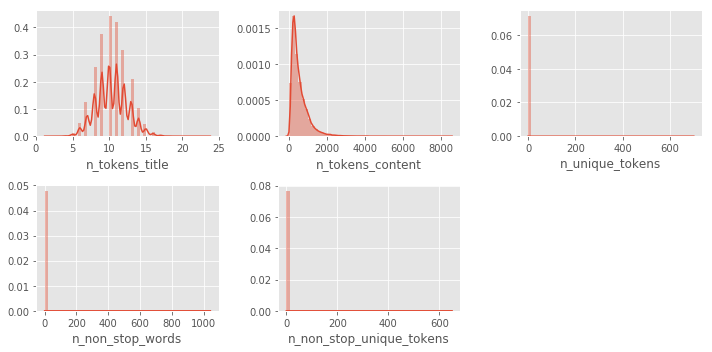

In [7]:
plt.rcParams['figure.figsize'] = (10, 5)
hlp.grid_plot_batch(qnty, 3, sns.distplot)

<span style="color:brown">**`n_token_titles` presenta valores discretos, `n_tokens_content` es candidato a transformación logarítmica, mientras que los 3 últimos sólo presentan un único valor**
</span>

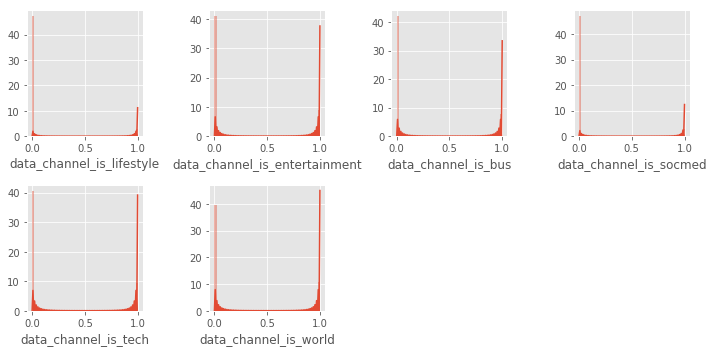

In [8]:
hlp.grid_plot_batch(channel, 4, sns.distplot)

<span style="color:brown">**variables `data_channel` están binarizadas.**
</span>

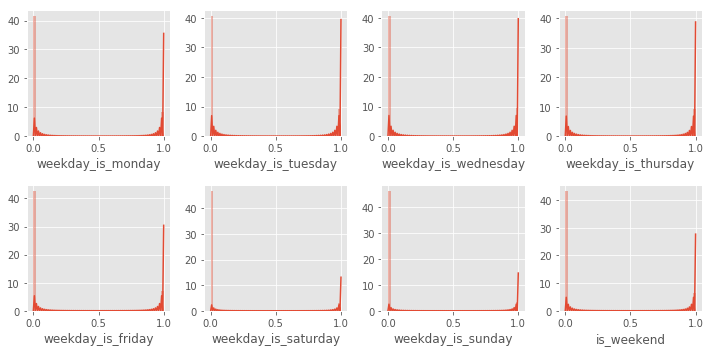

In [9]:
hlp.grid_plot_batch(days, 4, sns.distplot)

<span style="color:brown">**variables `weekday` están binarizadas.**
</span>

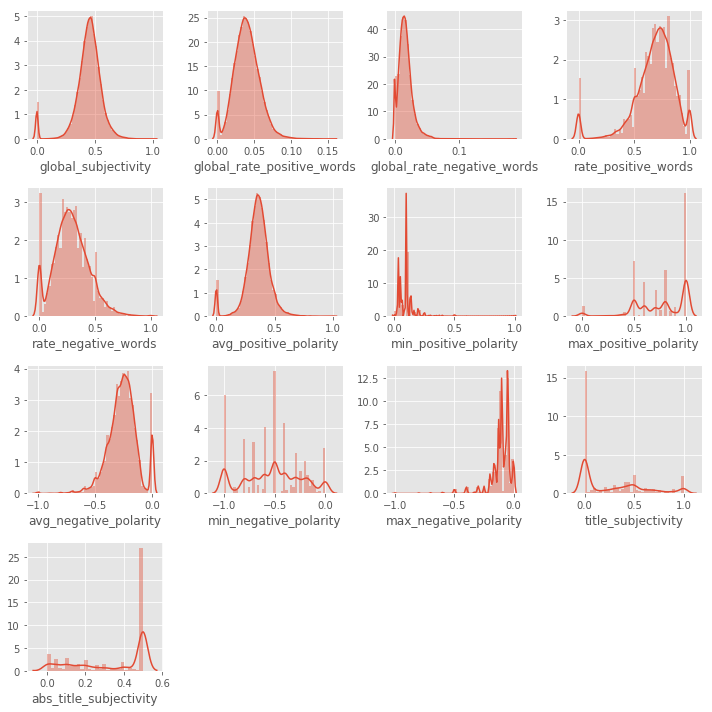

In [10]:
plt.rcParams['figure.figsize'] = (10, 10)
hlp.grid_plot_batch(sentiments, 4, sns.distplot)

<span style="color:brown">**Tenemos variables candidatas a transformación logarítmica, y variables con valores discretos.**
</span>

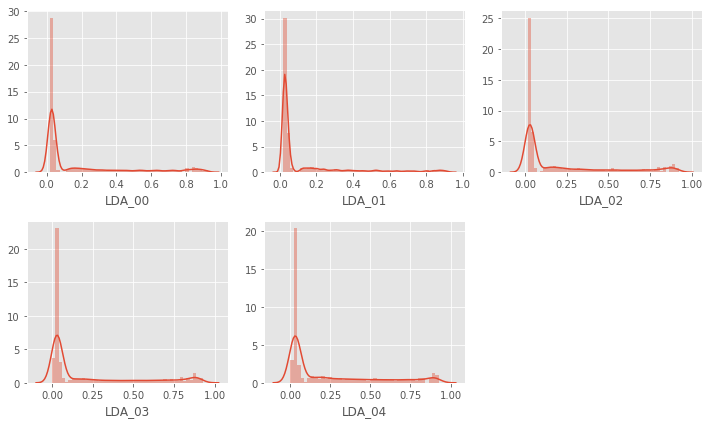

In [11]:
plt.rcParams['figure.figsize'] = (10, 6)
hlp.grid_plot_batch(lda, 3, sns.distplot)

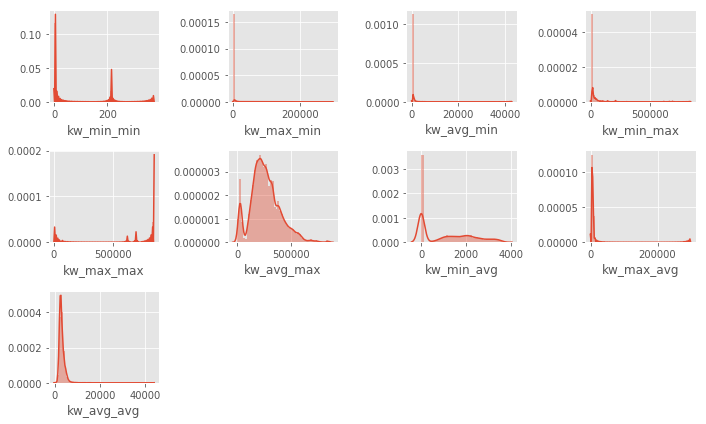

In [12]:
plt.rcParams['figure.figsize'] = (10, 6)
hlp.grid_plot_batch(keywords, 4, sns.distplot)

In [13]:
#Identificar variables correlacionadas
tmp = hlp.identify_high_correlations(df, threshold=.8)
tmp

variable                       var2     value
179             n_non_stop_words            n_unique_tokens  0.999572
238     n_non_stop_unique_tokens            n_unique_tokens  0.999852
239     n_non_stop_unique_tokens           n_non_stop_words  0.999532
1139                  kw_avg_min                 kw_max_min  0.940529
1256                  kw_max_max                 kw_min_min -0.857226
1499                  kw_avg_avg                 kw_max_avg  0.811864
1678  self_reference_avg_sharess  self_reference_min_shares  0.818907
1679  self_reference_avg_sharess  self_reference_max_shares  0.853480
2317                      LDA_02      data_channel_is_world  0.836618

In [14]:
#Recodificar shares:  1 = >1400, 0 = resto
df['shares'] = np.where(df['shares'] > 1400, 1, 0)
df.shape

(39644, 59)

In [15]:
#Elimine todas las variables que presentaban una correlación mayor a .8:
tmp_list = list(tmp['variable'])+list(tmp['var2'])

In [16]:
#Elimine todas las variables que presentaban una correlación mayor a .8:
df_drop = df.drop(tmp_list, axis=1)
df_drop.shape

(39644, 45)

In [17]:
variables = list(df_drop.columns)
variables.pop(len(variables)-1)
len(variables)
#variables

44

In [18]:
#Análisis de Componentes Principales para extraer las principales 30 dimensiones; requiere StandardScaler
tmp = df_drop.columns
x = df_drop.loc[:, variables].values
x

array([[ 1.20000000e+01,  2.19000000e+02,  4.00000000e+00, ...,
        -1.87500000e-01,  0.00000000e+00,  1.87500000e-01],
       [ 9.00000000e+00,  2.55000000e+02,  3.00000000e+00, ...,
         0.00000000e+00,  5.00000000e-01,  0.00000000e+00],
       [ 9.00000000e+00,  2.11000000e+02,  3.00000000e+00, ...,
         0.00000000e+00,  5.00000000e-01,  0.00000000e+00],
       ...,
       [ 1.00000000e+01,  4.42000000e+02,  2.40000000e+01, ...,
         1.36363636e-01,  4.54545455e-02,  1.36363636e-01],
       [ 6.00000000e+00,  6.82000000e+02,  1.00000000e+01, ...,
         0.00000000e+00,  5.00000000e-01,  0.00000000e+00],
       [ 1.00000000e+01,  1.57000000e+02,  1.00000000e+00, ...,
         2.50000000e-01,  1.66666667e-01,  2.50000000e-01]])

In [19]:
y = df_drop.loc[:, 'shares'].values
y

array([0, 0, 1, ..., 1, 0, 0])

In [20]:
x_std = StandardScaler().fit_transform(x)

In [21]:
#convertir los datos en df
pd.DataFrame(data = x_std, columns = variables).head()

n_tokens_title  n_tokens_content  num_hrefs  num_self_hrefs  num_imgs  \
0        0.757447         -0.695210  -0.607463       -0.335566 -0.426526   
1       -0.661657         -0.618794  -0.695709       -0.594963 -0.426526   
2       -0.661657         -0.712192  -0.695709       -0.594963 -0.426526   
3       -0.661657         -0.032933  -0.166229       -0.854360 -0.426526   
4        1.230482          1.115439   0.716237        4.074185  1.860061   

   num_videos  average_token_length  num_keywords  data_channel_is_lifestyle  \
0   -0.304268              0.156474     -1.164821                  -0.236445   
1   -0.304268              0.432838     -1.688626                  -0.236445   
2   -0.304268             -0.183415     -0.641015                  -0.236445   
3   -0.304268             -0.169758     -0.117210                  -0.236445   
4   -0.304268              0.159400     -0.117210                  -0.236445   

   data_channel_is_entertainment  ...  avg_positive_polarity  \
0                       2.148880  ...               0.237337   
1                      -0.465359  ...              -0.640040   
2                      -0.465359  ...               1.358401   
3                       2.148880  ...               0.307442   
4                      -0.465359  ...               0.548135   

   min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
0               0.063865              -0.228941              -0.708369   
1              -0.870968              -0.228941               1.102174   
2               0.063865               0.981798              -1.621797   
3               0.573773               0.174639              -0.862584   
4              -0.870968               0.981798               0.307944   

   min_negative_polarity  max_negative_polarity  title_subjectivity  \
0              -0.268895              -0.969886            0.671245   
1               1.367424               0.078642           -0.870807   
2              -0.957871              -0.270867           -0.870807   
3              -0.268895              -0.620377           -0.870807   
4               0.075594               0.602906            0.531059   

   title_sentiment_polarity  abs_title_subjectivity  \
0                 -0.975432               -1.810719   
1                 -0.269076                0.837749   
2                 -0.269076                0.837749   
3                 -0.269076                0.837749   
4                  0.244637               -1.569949   

   abs_title_sentiment_polarity  
0                      0.138920  
1                     -0.689658  
2                     -0.689658  
3                     -0.689658  
4                     -0.087056  

[5 rows x 44 columns]

In [22]:
pca = PCA(n_components=30)

In [23]:
pca_fit = pca.fit_transform(x_std)

In [24]:
print("La varianza explicada de cada dimensión es de:", pca.explained_variance_ratio_)
print("\nEn conjunto, ambas dimensiones explican la varianza en un: ", sum(pca.explained_variance_ratio_))
print("\nEn conjunto, ambas dimensiones explican la varianza en un: ", np.cumsum(pca.explained_variance_ratio_)) 
#también sirve

La varianza explicada de cada dimensión es de: [0.10552208 0.08602823 0.06147981 0.05766724 0.04971791 0.04545988
 0.04451544 0.04200949 0.03306466 0.03127279 0.02807231 0.02794126
 0.02766343 0.02716547 0.0267719  0.02621381 0.0253676  0.02403627
 0.02108478 0.0195787  0.01847988 0.01631536 0.0155749  0.01513438
 0.01427652 0.0133808  0.0123895  0.01095726 0.01045133 0.0102216 ]

En conjunto, ambas dimensiones explican la varianza en un:  0.947814598513076

En conjunto, ambas dimensiones explican la varianza en un:  [0.10552208 0.19155031 0.25303013 0.31069736 0.36041527 0.40587515
 0.45039059 0.49240008 0.52546474 0.55673753 0.58480984 0.61275111
 0.64041454 0.66758001 0.6943519  0.72056571 0.74593331 0.76996958
 0.79105436 0.81063306 0.82911295 0.84542831 0.86100321 0.87613759
 0.89041411 0.90379491 0.91618441 0.92714167 0.937593   0.9478146 ]


In [25]:
df_obj = df_drop['shares']
df_obj.shape

(39644,)

In [26]:
#guardarlo como dataframe para usarla en los sets de entrenamiento/validación
df_pca = pd.DataFrame(pca_fit, columns=variables[0:30])
df_pca.sample(5)

n_tokens_title  n_tokens_content  num_hrefs  num_self_hrefs  num_imgs  \
18984       -0.158275         -1.442967  -1.851945       -1.000765 -0.127422   
17449       -0.585690         -0.184644   3.471574        1.304118 -2.184035   
17904       -0.849112         -0.213213  -2.899927        2.166222  1.430176   
16814       -0.832057          3.606209   0.644900       -0.063190 -1.250242   
35783        9.862919         -0.413275   1.294063        1.616324  1.108444   

       num_videos  average_token_length  num_keywords  \
18984   -0.009146              0.496891      1.176910   
17449    0.514580              0.833011      0.362717   
17904    1.964849             -2.176565      0.675234   
16814    0.064519             -1.270597      1.862494   
35783   -0.090802              2.201961      1.051045   

       data_channel_is_lifestyle  data_channel_is_entertainment  ...  \
18984                  -0.344826                       0.117000  ...   
17449                  -0.209728                       2.792715  ...   
17904                   1.328941                      -0.365265  ...   
16814                  -1.894309                      -1.551866  ...   
35783                  -0.448046                       0.695433  ...   

       weekday_is_friday  weekday_is_saturday  weekday_is_sunday  is_weekend  \
18984          -0.718806             0.470585           0.498838   -0.672838   
17449           0.385940             0.120310          -1.401327   -0.509942   
17904          -0.007691            -0.376372           0.331189    0.425296   
16814           0.489295            -1.011154           0.248557    0.152549   
35783          -0.058936            -1.477524           0.704302   -0.654467   

         LDA_00    LDA_01    LDA_03    LDA_04  global_subjectivity  \
18984  1.352863  0.581297 -0.630049  1.039797            -0.405294   
17449  0.056797  0.359319  0.339267 -1.126233            -0.332696   
17904 -0.006926 -0.716478  0.412367 -0.628057             0.110429   
16814  0.608085 -1.484103  1.100682 -0.390495            -0.542852   
35783 -1.036478 -0.859535  0.618852  0.657171             0.244259   

       global_sentiment_polarity  
18984                   0.459290  
17449                   0.378544  
17904                   0.023415  
16814                   0.510549  
35783                  -0.104842  

[5 rows x 30 columns]

## Ejercicio 2 - Evaluación de modelos individuales
- A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
  - Importe los módulos correctamente.
  - Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a `Precision`, `Recall`, `F1`. Puede hacer uso de la función `plot_classification_report` disponible en el archivo `helpers.py`.
  - Comente el desempeño general de cada uno

- La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
  - Regresión Logística.
  - Algoritmo de KMedias.
  - Árbol de Clasificación con un `max_depth=1`.
  - Árbol de Clasificación con un `max_depth=4`.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_pca,
                                                    df_obj,
                                                    test_size=.33, random_state=11238)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(26561, 30) (26561,)
(13083, 30) (13083,)


***MODELO REGRESIÓN LOGÍSTICA***

In [28]:
model_lr = linear_model.LogisticRegression(solver = 'lbfgs')
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
#no funcionó el de helpers... usar el de siempre
clss_rpt_lr = classification_report(y_test, model_lr.predict(X_test))
print(clss_rpt_lr)

              precision    recall  f1-score   support

           0       0.62      0.66      0.64      6655
           1       0.63      0.59      0.61      6428

    accuracy                           0.63     13083
   macro avg       0.63      0.63      0.63     13083
weighted avg       0.63      0.63      0.63     13083



<span style="color:brown">**Desempeño de modelo no es tan bueno, con todas las métricas bajo el 80%: *precisión* del 63%, *recall* del 59% y *F1-score* del 61%.**
</span>

***MODELO KMEANS***

done in 343.969s.


Text(0, 0.5, 'Inercia estimada')

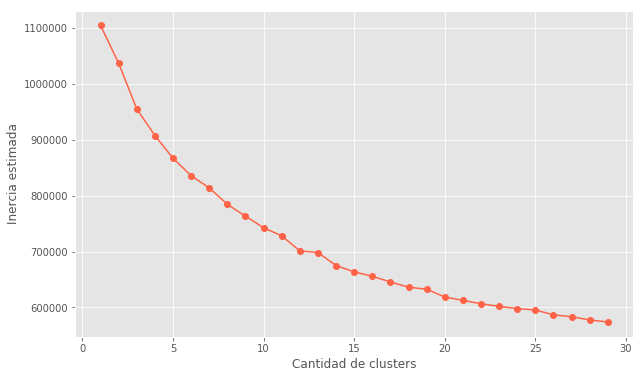

In [30]:
#Verificar n° de clusters a usar.
cols = X_train.shape[1]
inertia = []
t0 = time()

for i in range(1, cols):
    inertia.append(KMeans(n_clusters=i, random_state=11238).fit(X_train).inertia_)

print("done in %0.3fs." % (time() - t0))

# graficamos el resultado
plt.plot(range(1, cols), inertia, 'o-', color='tomato')
plt.xlabel("Cantidad de clusters")
plt.ylabel("Inercia estimada")

In [31]:
# entreno modelo kmeans con 25 cluster según lo indica el gráfico
kmeans = KMeans(n_clusters=25, random_state=11238)
kmeans = kmeans.fit(X_train)

In [32]:
#qué tan equidistribuidas están estas etiquetas
pd.Series(kmeans.labels_).value_counts('%')

11    0.072964
4     0.069877
2     0.068183
7     0.060276
3     0.054968
18    0.052822
20    0.050789
23    0.049885
16    0.049697
12    0.049095
1     0.048643
6     0.043974
19    0.043184
13    0.042657
10    0.033771
22    0.032567
17    0.032002
5     0.029404
15    0.027371
21    0.023870
14    0.020971
9     0.019766
0     0.017883
8     0.005384
dtype: float64

In [33]:
kmeans.inertia_

598028.2199099842

***MODELO CLASSIFICATION TREE max_depth=1***

In [34]:
# Entrenamos el decision stump
decision_stump1 = DecisionTreeClassifier(max_depth=1, random_state=11238)
decision_stump1_fit = decision_stump1.fit(X_train, y_train)

In [35]:
clss_rpt_ds1 = classification_report(y_test, decision_stump1_fit.predict(X_test))
print(clss_rpt_ds1)

              precision    recall  f1-score   support

           0       0.53      0.93      0.67      6655
           1       0.66      0.15      0.25      6428

    accuracy                           0.55     13083
   macro avg       0.60      0.54      0.46     13083
weighted avg       0.60      0.55      0.46     13083



<span style="color:brown">**Desempeño de modelo más bien pobre: *precisión* del 66%, pero *recall* del 15% y *F1-score* del 25%.**
</span>

***MODELO CLASSIFICATION TREE max_depth=4***

In [36]:
# Entrenamos el decision stump
decision_stump4 = DecisionTreeClassifier(max_depth=4, random_state=11238)
decision_stump4_fit = decision_stump4.fit(X_train, y_train)

In [37]:
clss_rpt_ds4 = classification_report(y_test, decision_stump4_fit.predict(X_test))
print(clss_rpt_ds4)

              precision    recall  f1-score   support

           0       0.61      0.69      0.65      6655
           1       0.63      0.54      0.58      6428

    accuracy                           0.62     13083
   macro avg       0.62      0.62      0.61     13083
weighted avg       0.62      0.62      0.61     13083



<span style="color:brown">**Desempeño mejor al anterior: *precisión* del 63%, pero *recall* del 54% y *F1-score* del 58%.**
</span>

## Ejercicio 3 - Entrenamiento de Comité
- Entrene el comité de clasificadores sin modificar el esquema de votación.
- Reporte el desempeño a nivel de cada clase para cada métrica.

In [38]:
#graficar desempeño clasificadores
def plot_classification_report(y_test, class_pred, dummy_class=False):
    """TODO: Docstring for plot_classification_report.

    :y_test: TODO
    :class_pred: TODO
    :dummy_class: TODO
    :returns: TODO

    """

    colors = ['dodgerblue', 'tomato']
    report = pd.DataFrame(classification_report(y_test, class_pred, output_dict=True))
    class_specific_values = report.drop(columns=['accuracy', 'macro avg', 'weighted avg'])
    class_specific_values = report.loc[:, class_specific_values.columns].T
    macro_avg = report.drop(index='support')['macro avg']

    for index, value in enumerate(class_specific_values.index):
        plt.scatter(class_specific_values['precision'][value], [1], marker='x', c=colors[index])
        plt.scatter(class_specific_values['recall'][value], [2], marker='x', c=colors[index])
        plt.scatter(class_specific_values['f1-score'][value], [3], marker='x', c=colors[index], label=f"Class: {index}")

    plt.scatter(macro_avg, [1, 2, 3], color='forestgreen', label='Macro Average')
    plt.yticks([1.0, 2.0, 3.0], ['Precision', 'Recall', 'F1-Score'])

    if dummy_class is True:
        plt.axvline(.5, label = '.5 Boundary', linestyle='--')

    plt.legend(loc='center left', bbox_to_anchor=(1, .5))

In [39]:
# definimos el comité de clasificadores en una lista de tuplas
estimators = [('Logistic Regression', LogisticRegression(solver = 'lbfgs')),
              ('KMeans', KMeans(n_clusters=2, random_state=11238)), #en 2 para poder hacer la gráfica comparativa!
              ('Decision Tree Classifier 1', DecisionTreeClassifier(max_depth=1, random_state=11238)),
              ('Decision Tree Classifier 4', DecisionTreeClassifier(max_depth=4, random_state=11238)),
             ]

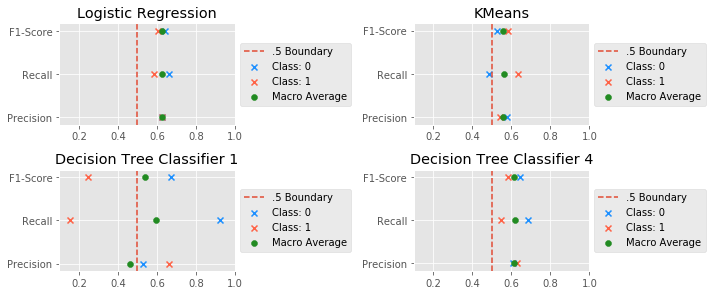

In [40]:
#observar el desempeño de cada clasificador
for index, value in enumerate(estimators):
    plt.subplot(3, 2, index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    plot_classification_report(y_test, class_pred, dummy_class=True)
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

<span style="color:brown">**'Decission Tree Classifier 1' muestra claramente el peor desempeño, y 'Logistic Regression', el mejor.**
</span>

## Ejercicio 4 - Calibración de Comité con Ponderadores
- El base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
- Reporte el desempeño del mejor ensamble heterogéneo.

```python
#función 'weighting_schedule' del archivo adicional proporcionado no funcionó con estos parámetros:
#   buscar otra alternativa!!!
```
<span style="color:brown">**De acuerdo al comportamiento anterior, se decide dos esquemas de ponderación:**
- De mayor a menor peso: 'Logistic Regression', 'KMeans' (24 clusters), 'Decision Tree Classifier 4', 'Decission Tree Classifier 1'
- mismo orden, pero eliminando 'Decision Tree Classifier 1'
</span>


In [41]:
# definimos el comité de clasificadores en una lista de tuplas
estimators = [('Logistic Regression', LogisticRegression(solver = 'lbfgs')),
              ('KMeans', KMeans(n_clusters=24, random_state=11238)), #ahora sí el que vale
              ('Decision Tree Classifier 1', DecisionTreeClassifier(max_depth=1, random_state=11238)),
              ('Decision Tree Classifier 4', DecisionTreeClassifier(max_depth=4, random_state=11238)),
             ]

In [42]:
# VotingClassifier requiere de la lista de tuplas que definimos arriba
voting_classifier = VotingClassifier(estimators, weights=[4,3,1,2]).fit(X_train, y_train)

yhat = voting_classifier.fit(X_train,y_train).predict(X_test)

              precision    recall  f1-score   support

           0       0.62      0.67      0.64      6655
           1       0.63      0.58      0.60      6428

    accuracy                           0.63     13083
   macro avg       0.63      0.62      0.62     13083
weighted avg       0.63      0.63      0.62     13083



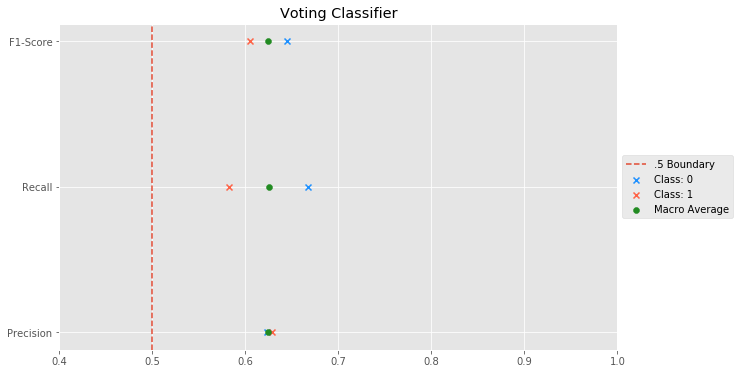

In [43]:
print(classification_report(y_test, yhat))

plot_classification_report(y_test, yhat, dummy_class=True)
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [44]:
# definimos el comité de clasificadores en una lista de tuplas
estimators = [('Logistic Regression', LogisticRegression(solver = 'lbfgs')),
              ('KMeans', KMeans(n_clusters=24, random_state=11238)), #ahora sí el que vale
              ('Decision Tree Classifier 4', DecisionTreeClassifier(max_depth=4, random_state=11238)),
             ]

In [45]:
# Segunda opción
voting_classifier = VotingClassifier(estimators, weights=[4,2,1]).fit(X_train, y_train)
yhat = voting_classifier.fit(X_train,y_train).predict(X_test)

              precision    recall  f1-score   support

           0       0.62      0.66      0.64      6655
           1       0.63      0.59      0.61      6428

    accuracy                           0.63     13083
   macro avg       0.63      0.63      0.63     13083
weighted avg       0.63      0.63      0.63     13083



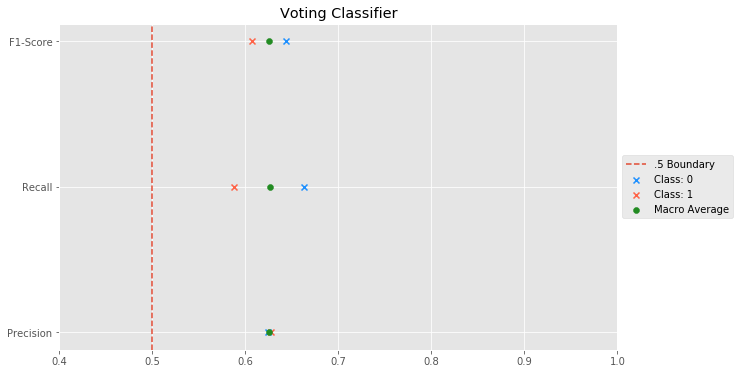

In [46]:
print(classification_report(y_test, yhat))

plot_classification_report(y_test, yhat, dummy_class=True)
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

<span style="color:brown">**El segundo es el mejor modelo heterogéneo; no es tan buen modelo (menor al 80%), pero es mejor al 50% que entregaría un modelo al azar.**
</span>